In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
%env NUMEXPR_MAX_THREADS=16
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: NUMEXPR_MAX_THREADS=16
Mon Feb 26 20:15:08 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   51C    P0    74W / 275W |    497MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[20:15:11.000] INFO   CaloQVAE                                          Willkommen!
[20:15:11.001] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2024-02-26 20:15:11,942 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[20:15:11.942] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[20:15:13.248] INFO   data.dataManager                                  Loading Data
[20:15:19.195] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f0bcaa215d0>: 80000 events, 625 batches
[20:15:19.197] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f0bca4dfd10>: 10000 events, 10 batches
[20:15:19.197] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f0bca4df110>: 10000 events, 10 batches
[20:15:21.565] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNNnohits
2024-02-26 20

Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[20:15:26.665] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[20:15:26.942] INFO   engine.engineAtlasV2                              Setting up engine AtlaV2s.
[20:15:26.943] INFO   engine.engineAtlas                                Setting up engine Atlas.
[20:15:26.943] INFO   engine.engineCaloV3                               Setting up engine Calo.
[20:15:26.943] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[20:15:33.691] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f0b3fedde10>: 80000 events, 625 batches
[20:15:33.693] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f0b5ca5afd0>: 10000 events, 10 batches
[20:15:33.693] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f0de12f7790>: 10000 events, 10 batches


In [134]:
from multiprocessing import Pool

def run_chain(chain_id, num_iterations):
    # Initialize your chain state
    state = initialize_state()
    
    for i in range(num_iterations):
        # Perform Gibbs sampling iteration
        state = gibbs_iteration(state)
    
    return state

# if __name__ == "__main__":
#     num_chains = 4
#     num_iterations = 1000
    
#     with Pool(num_chains) as p:
#         results = p.starmap(run_chain, [(i, num_iterations) for i in range(num_chains)])


In [10]:
# # if __name__ == "__main__":
# num_chains = 4
# num_iterations = 1000

# with Pool(num_chains) as p:
#     results = p.starmap(run_chain, [(i, num_iterations) for i in range(num_chains)])


In [68]:
class testNN(nn.Module):
    def __init__(self):
        super(testNN, self).__init__()
        self.seq1 = nn.Sequential(nn.Linear(6480,500),
                                 nn.Linear(500,6480))
    def forward(self,x):
        x = self.seq1(x)
        return x

In [75]:
tNN = testNN()

In [147]:
post_zetas.detach()

tensor([[-4.9169, -1.1374, -0.7950,  ...,  1.6354,  0.0647, -4.1715],
        [-9.0906, 10.4487,  4.0008,  ...,  7.7338, -2.8452, -5.9641],
        [-5.5920, -1.3046, -0.9091,  ...,  1.7349,  0.0754, -4.5044],
        ...,
        [-4.8065, -0.9802, -0.7255,  ...,  1.6110,  0.0720, -4.1149],
        [-4.4763, -0.8705, -0.6533,  ...,  1.5504,  0.0633, -3.9122],
        [-5.3222, -1.2084, -0.8548,  ...,  1.6965,  0.0765, -4.3828]],
       device='cuda:4')

In [158]:
# post_zetas = torch.cat(fwd_output.post_logits, 1)
# post_zetas
# run_chain(post_zetas, 512, method='CD')

# num_chains = 4  # Number of chains to run in parallel
# num_iterations = 1000  # Number of iterations per chain
# initial_states = [post_zetas.detach(),post_zetas.detach(),post_zetas.detach(),post_zetas.detach()]  # Initial states for each chain
# devices = ['cuda:4']  # Adjust based on your GPUs

# # Arguments for each chain
# args = [(i, initial_states[i], num_iterations, devices[i % len(devices)]) for i in range(num_chains)]

# with Pool(processes=num_chains) as pool:
#     results = pool.map(run_chain_wrapper, args)

# # `results` now contains the states for each chain

In [154]:
def energy_exp(p0_state, p1_state, p2_state, p3_state):
        """Energy expectation value under the 4-partite BM
        Overrides energy_exp in gumbolt.py

        :param p0_state (torch.Tensor) : (batch_size, n_nodes_p1)
        :param p1_state (torch.Tensor) : (batch_size, n_nodes_p2)
        :param p2_state (torch.Tensor) : (batch_size, n_nodes_p3)
        :param p3_state (torch.Tensor) : (batch_size, n_nodes_p4)

        :return energy expectation value over the current batch
        """
        w_dict = model.prior.weight_dict
        b_dict = model.prior.bias_dict

        w_dict_cp = {}

        # Broadcast weight matrices (n_nodes_pa, n_nodes_pb) to
        # (batch_size, n_nodes_pa, n_nodes_pb)
        for key in w_dict.keys():
            w_dict_cp[key] = w_dict[key] + torch.zeros((p0_state.size(0),) +
                                                    w_dict[key].size(),
                                                    device=w_dict[key].device)

        # Prepare px_state_t for torch.bmm()
        # Change px_state.size() to (batch_size, 1, n_nodes_px)
        p0_state_t = p0_state.unsqueeze(2).permute(0, 2, 1)
        p1_state_t = p1_state.unsqueeze(2).permute(0, 2, 1)
        p2_state_t = p2_state.unsqueeze(2).permute(0, 2, 1)

        # Prepare py_state for torch.bmm()
        # Change py_state.size() to (batch_size, n_nodes_py, 1)
        p1_state_i = p1_state.unsqueeze(2)
        p2_state_i = p2_state.unsqueeze(2)
        p3_state_i = p3_state.unsqueeze(2)

        # Compute the energies for batch samples
        batch_energy = -torch.matmul(p0_state, b_dict['0']) - \
            torch.matmul(p1_state, b_dict['1']) - \
            torch.matmul(p2_state, b_dict['2']) - \
            torch.matmul(p3_state, b_dict['3']) - \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['01'], p1_state_i)).reshape(-1) - \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['02'], p2_state_i)).reshape(-1) - \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['03'], p3_state_i)).reshape(-1) - \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['12'], p2_state_i)).reshape(-1) - \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['13'], p3_state_i)).reshape(-1) - \
            torch.bmm(p2_state_t,
                      torch.bmm(w_dict_cp['23'], p3_state_i)).reshape(-1)

        return torch.mean(batch_energy, dim=0)

def kl_divergence(post_logits, post_samples, is_training=True):
        """Overrides kl_divergence in GumBolt.py

        :param post_logits (list) : List of f(logit_i|x, e) for each hierarchy
                                    layer i. Each element is a tensor of size
                                    (batch_size * n_nodes_per_hierarchy_layer)
        :param post_zetas (list) : List of q(zeta_i|x, e) for each hierarchy
                                   layer i. Each element is a tensor of size
                                   (batch_size * n_nodes_per_hierarchy_layer)
        """
        # Concatenate all hierarchy levels
        logits_q_z = torch.cat(post_logits, 1)
        post_zetas = torch.cat(post_samples, 1)

        # Compute cross-entropy b/w post_logits and post_samples
        entropy = - nn.BCEWithLogitsLoss(reduction="none")(logits_q_z, post_zetas)
        entropy = torch.mean(torch.sum(entropy, dim=1), dim=0)

        # Compute positive phase (energy expval under posterior variables) 
        n_nodes_p = 512
        pos_energy = energy_exp(post_zetas[:, :n_nodes_p],
                                     post_zetas[:, n_nodes_p:2*n_nodes_p],
                                     post_zetas[:, 2*n_nodes_p:3*n_nodes_p],
                                     post_zetas[:, 3*n_nodes_p:])

        # Compute gradient computation of the logZ term
        p0_state, p1_state, p2_state, p3_state = model.sampler.block_gibbs_sampling(post_zetas[:, :n_nodes_p],
                                     post_zetas[:, n_nodes_p:2*n_nodes_p],
                                     post_zetas[:, 2*n_nodes_p:3*n_nodes_p],
                                     post_zetas[:, 3*n_nodes_p:], method='CD')
        p0_state, p1_state, p2_state, p3_state = run_chain(post_zetas, n_nodes_p, method='CD')
        

        
        neg_energy = - energy_exp(p0_state, p1_state, p2_state, p3_state)

        # Estimate of the kl-divergence
        kl_loss = entropy + pos_energy + neg_energy
        return kl_loss, entropy, pos_energy, neg_energy
    
def run_chain(post_zetas, n_nodes_p, method='CD'):
    p0_state, p1_state, p2_state, p3_state = model.sampler.block_gibbs_sampling(post_zetas[:, :n_nodes_p],
                                     post_zetas[:, n_nodes_p:2*n_nodes_p],
                                     post_zetas[:, 2*n_nodes_p:3*n_nodes_p],
                                     post_zetas[:, 3*n_nodes_p:], method)
#     # Initialize your chain state
#     state = initialize_state()
    
#     for i in range(num_iterations):
#         # Perform Gibbs sampling iteration
#         state = gibbs_iteration(state)
    
    return p0_state, p1_state, p2_state, p3_state

def gibbs_sampling_chain(chain_id, post_zetas, n_nodes_p, num_iterations, device, method='CD'):
    """
    Runs a single Gibbs sampling chain.

    Parameters:
    - chain_id: Identifier for the chain (useful for debugging).
    - initial_state: Initial state for the chain.
    - num_iterations: Number of Gibbs sampling iterations to run.
    - device: PyTorch device (e.g., 'cuda:0') to perform computations on.

    Returns:
    - A list of states visited by the chain.
    """
    p0_state, p1_state, p2_state, p3_state = model.sampler.block_gibbs_sampling(post_zetas[:, :n_nodes_p],
                                     post_zetas[:, n_nodes_p:2*n_nodes_p],
                                     post_zetas[:, 2*n_nodes_p:3*n_nodes_p],
                                     post_zetas[:, 3*n_nodes_p:], method)
    
    return p0_state, p1_state, p2_state, p3_state

# from multiprocessing import Pool
# import torch

def run_chain_wrapper(args):
    return gibbs_sampling_chain(*args)


def loss(input_data, fwd_out, true_energy):
    """
    - Overrides loss in gumboltCaloV5.py
    """
    logger.debug("loss")

    kl_loss, entropy, pos_energy, neg_energy = kl_divergence(fwd_out.post_logits, fwd_out.post_samples)
    # ae_loss = self._output_loss(input_data, fwd_out.output_activations) * torch.exp(self._config.model.mse_weight*input_data)
    sigma = 2 * torch.sqrt(torch.max(input_data, torch.min(input_data[input_data>0])))
    interpolation_param = 1
    ae_loss = torch.pow((input_data - fwd_out.output_activations)/sigma,2) * (1 - interpolation_param + interpolation_param*torch.pow(sigma,2))
    ae_loss = torch.mean(torch.sum(ae_loss, dim=1), dim=0)

    #hit_loss = self._hit_loss(fwd_out.output_hits, torch.where(input_data > 0, 1., 0.))
    #hit_loss = torch.mean(torch.sum(hit_loss, dim=1), dim=0)
    hit_loss = binary_cross_entropy_with_logits(fwd_out.output_hits, torch.where(input_data > 0, 1., 0.), reduction='none')
    # spIdx = torch.where(input_data > 0, 0., 1.).sum(dim=1) / input_data.shape[1]
    # sparsity_weight = torch.exp(self._config.model.alpha - self._config.model.gamma * spIdx)
    hit_loss = torch.mean(torch.sum(hit_loss, dim=1), dim=0)

    # labels_target = nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float)
    # hit_label = binary_cross_entropy_with_logits(fwd_out.labels, labels_target)


    # if self._config.engine.modelhits:
    # return {"ae_loss":ae_loss, "kl_loss":kl_loss, "hit_loss":hit_loss*0.3,
            # "entropy":entropy, "pos_energy":pos_energy, "neg_energy":neg_energy}
    return ae_loss + hit_loss #+ kl_loss
   

In [118]:
import h5py
from torch.utils.data import TensorDataset, DataLoader

class DataManager(object):
    def __init__(self,train_loader=None,test_loader=None,val_loader=None, cfg=None):
        self._config=cfg
        
        self._train_loader=train_loader
        self._test_loader=test_loader
        self._val_loader=val_loader

        #this is a list of tensor.shape tuples (i.e.[(28,28)] for MNIST) 
        self._input_dimensions=None
        #list of flattened tensor.shape tuples (i.e. [784] for mnist)
        self._flat_input_sizes=None 

        self._train_dataset_means=None
        
        # Variables to be used in the scaling and inverse scaling
        self._amin_array = None
        self._transformer = None
        # return
        self.particle_type = [self._config.data.particle_type]
        self.frac_train_dataset=self._config.data.frac_train_dataset
        self.frac_test_dataset=self._config.data.frac_test_dataset
        self.load_dataset_directories()
        
        
    def load_dataset_directories(self):
        if self._config.data.data_type.lower()=="atlas":
            self.inFiles={
            'photon1':    self._config.data.atlas_input_photon1,
                'photonEn0':    self._config.data.atlas_input_photonEn0,
                'photonEn1':    self._config.data.atlas_input_photonEn1,
                'photonEn2':    self._config.data.atlas_input_photonEn2,
                'photonEn3':    self._config.data.atlas_input_photonEn3,
                'photonEn4':    self._config.data.atlas_input_photonEn4,
                'photonEn5':    self._config.data.atlas_input_photonEn5,
                'photonEn6':    self._config.data.atlas_input_photonEn6,
                'photonEn7':    self._config.data.atlas_input_photonEn7,
            'pion1':   self._config.data.atlas_input_pion1,
                'pionEn0':   self._config.data.atlas_input_pionEn0,
                'pionEn1':   self._config.data.atlas_input_pionEn1,
                'pionEn2':   self._config.data.atlas_input_pionEn2,
                'pionEn3':   self._config.data.atlas_input_pionEn3,
                'pionEn4':   self._config.data.atlas_input_pionEn4,
                'pionEn5':   self._config.data.atlas_input_pionEn5,
                'pionEn6':   self._config.data.atlas_input_pionEn6,
                'pionEn7':   self._config.data.atlas_input_pionEn7,
            'electron-ds2': self._config.data.atlas_input_electron,
        }
        
    def load_data(self):
        
        #read in all input files for all jet types and layers
        datastore={}
        for key,fpath in self.inFiles.items(): 
            if key in self.particle_type: 
                with h5py.File(fpath, 'r') as file:
                    # List all groups
                    # print("Keys: %s" % file.keys())
                    for other_key in file.keys():
                        datastore[other_key] = torch.tensor(file[other_key][:]).float()
                
                # in_data=h5py.File(fpath,'r')
                # #for each particle_type, create a Container instance for our needs   
                # dataStore[key]=CaloImageContainer(  particle_type=key,
                #                                     input_data=in_data,
                #                                     layer_subset=layer_subset)
                # #convert image dataframes to tensors and get energies
                # dataStore[key].process_data(input_data=in_data)

        assert len(self.particle_type)==1, f"Currently one particle type at a time\
             can be retrieved. Requested {self.particle_type}"
        ptype=self.particle_type[0]

        #let's split our datasets
        #get total num evts
        num_evts_total=datastore['showers'].shape[0]
        print(num_evts_total)

        #create a sequential list of indices
        # idx_list = [i for i in range(0, num_evts_total)]

        # compute number of split evts from fraction
        num_evts_train = int(self.frac_train_dataset*num_evts_total)
        num_evts_test = int(self.frac_test_dataset*num_evts_total)

        #create lists of split indices
        # train_idx_list = idx_list[:num_evts_train]
        # test_idx_list = idx_list[num_evts_train:(num_evts_train+num_evts_test)]
        # val_idx_list = idx_list[(num_evts_train+num_evts_test):]

        # train_dataset = dataStore[ptype].create_subset(idx_list=train_idx_list, label="train")
        # test_dataset = dataStore[ptype].create_subset(idx_list=test_idx_list, label="test")
        # val_dataset = dataStore[ptype].create_subset(idx_list=val_idx_list, label="val")
        
        self.train_dataset =  TensorDataset(datastore['showers'][:num_evts_train,:], datastore['incident_energies'][:num_evts_train,:])
        self.test_dataset =  TensorDataset(datastore['showers'][num_evts_train:num_evts_train+num_evts_test,:], datastore['incident_energies'][num_evts_train:num_evts_train+num_evts_test,:])
        self.val_dataset =  TensorDataset(datastore['showers'][num_evts_train+num_evts_test:,:], datastore['incident_energies'][num_evts_train+num_evts_test:,:])

        return self.train_dataset, self.test_dataset, self.val_dataset
        
    def create_dataLoader(self):
        assert abs(self._config.data.frac_train_dataset-1)>=0, "Cfg option frac_train_dataset must be within (0,1]"
        assert abs(self._config.data.frac_test_dataset-0.99)>1.e-5, "Cfg option frac_test_dataset must be within (0,99]. 0.01 minimum for validation set"

        self.load_data()
                
        #create the DataLoader for the training dataset
        train_loader=DataLoader(   
            self.train_dataset,
            batch_size=self._config.engine.n_train_batch_size, 
            num_workers=1, #self._config.num_workers,
            shuffle=True)

        #create the DataLoader for the testing/validation datasets
        #set batch size to full test/val dataset size - limitation only by hardware
        test_loader = DataLoader(
            self.test_dataset,
            batch_size=self._config.engine.n_test_batch_size, 
            num_workers=self._config.num_workers,
            shuffle=False)
        
        val_loader = DataLoader(
            self.val_dataset,
            batch_size=self._config.engine.n_valid_batch_size, 
            num_workers=self._config.num_workers,
            shuffle=False)

        # logger.info("{0}: {2} events, {1} batches".format(train_loader,len(train_loader),len(train_loader.dataset)))
        # logger.info("{0}: {2} events, {1} batches".format(test_loader,len(test_loader),len(test_loader.dataset)))
        # logger.info("{0}: {2} events, {1} batches".format(val_loader,len(val_loader),len(val_loader.dataset)))

        return train_loader,test_loader,val_loader

In [119]:
dataMgr = DataManager(cfg=config)
train_loader, te, va = dataMgr.create_dataLoader()

100000


In [120]:
tNN = model.to(dev);

In [121]:
# tNN = testNN().to(dev)
criterion = nn.MSELoss()
opt = optim.Adam(tNN.parameters(), lr=0.0001)

In [11]:
# # train_loader.num_workers
# # dataMgr.train_dataset.__len__()
# for batch_idx, (input_data, label) in enumerate(train_loader):
#     print(batch_idx)
#     opt.zero_grad()
#     in_data = input_data.to(dev)
#     true_energy = label.to(dev)

#     fwd_output = tNN((in_data, true_energy), True, beta_smoothing_fct, slope_act_fct)
    
#     batch_loss_dict = loss(in_data, fwd_output, true_energy)
    
# #     ae_gamma = 1. 

# #     batch_loss_dict["gamma"] = 1.0
# #     batch_loss_dict["LeakyReLUSlope"] = slope_act_fct
# #     batch_loss_dict["beta"] = beta_smoothing_fct
# #     batch_loss_dict["epoch"] = 1.0 *100

# #     batch_loss_dict["loss"] = ae_gamma*batch_loss_dict["ae_loss"] + 1.0*batch_loss_dict["entropy"] + 1.0 *batch_loss_dict["pos_energy"] + 1.0*batch_loss_dict["neg_energy"] 

# #     batch_loss_dict["loss"] = batch_loss_dict["loss"]
   
#     batch_loss_dict.backward()

#     opt.step()
#         # Trying this to free up memory on the GPU and run validation during a training epoch
#         # - hopefully backprop will work with the code above - didn't work
#         # batch_loss_dict["loss"].detach()

In [12]:
# # with torch.set_grad_enabled(is_training):
# beta_smoothing_fct = engine._config.engine.beta_smoothing_fct_final
# slope_act_fct = engine._config.engine.slope_activation_fct_final
# for batch_idx, (input_data, label) in enumerate(train_loader):
#     print(batch_idx)
#     engine._optimiser.zero_grad()
#     in_data = input_data.to(dev)
#     true_energy = label.to(dev)
#     # in_data, true_energy, in_data_flat = engine._preprocess(input_data, label)

#     # if self._config.engine.beta_smoothing_fct_anneal and self._config.load_state == 0:
#     #     beta_smoothing_fct = self.beta_value(epoch_anneal_start, num_batches, batch_idx, epoch)
#     # else:
    


#     # if self._config.engine.slope_activation_fct_anneal and self._config.load_state == 0:
#     #     slope_act_fct = self.slope_act_fct_value(epoch_anneal_start, num_batches, batch_idx, epoch)
#     # else:


#     fwd_output = engine._model((in_data, true_energy), True, beta_smoothing_fct, slope_act_fct)
#     # if self._config.reducedata:
#     #     in_data = self._reduceinv(in_data, true_energy, R=self.R)
#     #     fwd_output.output_activations = self._reduceinv(fwd_output.output_activations, true_energy, R=self.R)
#     batch_loss_dict = engine._model.loss(in_data, fwd_output, true_energy)


#     # if True:
#         # if epoch >= epoch_anneal_start:
#         #     # gamma = min((((epoch-epoch_anneal_start)*num_batches)+(batch_idx+1))/(total_batches*kl_annealing_ratio), self._config.engine.kl_gamma_max)
#         #     gamma = 1
#         # else:
#         #     gamma = 0
#         # if kl_enabled:
#         #     if kl_annealing:
#         #         kl_gamma = gamma
#         #     else:
#         #         kl_gamma = 1.
#         # else:
#         #     kl_gamma = 0.

#     ae_gamma = 1. 

#     batch_loss_dict["gamma"] = 1.0
#     batch_loss_dict["LeakyReLUSlope"] = slope_act_fct
#     batch_loss_dict["beta"] = beta_smoothing_fct
#     batch_loss_dict["epoch"] = 1.0 *100

#     batch_loss_dict["loss"] = ae_gamma*batch_loss_dict["ae_loss"] + 1.0*batch_loss_dict["entropy"] + 1.0 *batch_loss_dict["pos_energy"] + 1.0*batch_loss_dict["neg_energy"] 

#     batch_loss_dict["loss"] = batch_loss_dict["loss"].sum()
#     batch_loss_dict["loss"].backward()

#     engine._optimiser.step()
#         # Trying this to free up memory on the GPU and run validation during a training epoch
#         # - hopefully backprop will work with the code above - didn't work
#         # batch_loss_dict["loss"].detach()

In [13]:
###LOAD MODEL

In [12]:
_epoch = 0
if config.load_state:
    print("Loading model...")
    assert config.run_path != 0
    config_string = "_".join(str(i) for i in [config.model.model_type, config.data.data_type, config.tag])
    modelCreator.load_state(config.run_path, dev)
    # _epoch = get_epochs(config.run_path)
    # temp solution to get total number of epochs this model has been trained on
    # fn = create_filenames_dict(config.run_path)
    # _epoch = fn["size"]
    # if config.freeze_vae:
    #     for name, param in engine.model.named_parameters():
    #         if 'decoder' in name or 'encoder' in name:
    #             param.requires_grad = False
    #         print(name, param.requires_grad)
    #     engine.optimiser = torch.optim.Adam(filter(lambda p: p.requires_grad, engine.model.parameters()), lr=config.engine.learning_rate)

In [ ]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])
                    
                    
def load_RBM_state(run_path, device):
        logger.info("Loading RBM state")
        model_loc = run_path
        # Load the dictionary with all tensors mapped to the CPU
        loaded_dict = torch.load(model_loc, map_location=device)
        return loaded_dict
    
# ww = load_RBM_state("/home/javier/Projects/CaloQVAE/outputs/2023-11-20/16-54-48/wandb/latest-run/files/RBM_1_0_weights.pth", dev)

In [47]:
150*0.3*0.3

13.5

In [10]:
##############

# happy-sun-270 | CNN + voxel pos enc + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'happy-sun-270'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True

    
# drawn-cosmos-266 | CNN + cond + scaled data
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'drawn-cosmos-266'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  
    


# # misty-wind-267 | CNN + voxel pos enc JQTM + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'misty-wind-267'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    

    
# # winter-glade-268 | CNN + cond pos enc + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'winter-glade-268'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    


# # prime-totem-282 | CNN + voxel pos enc + cond + scaled data
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'prime-totem-282'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  


# smoldering-candles | CNN + cond + scaled data + no hits
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
modelname = 'smoldering-candles-302'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/19-34-51/wandb/run-20240213_193452-zrjorwol/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 
    
    
# generous-elevator | CNN + cond + scaled data + no hits
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth"
modelname = 'generous-elevator-301'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True 


arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[20:15:33.726] INFO   models.modelCreator                               Loading state
[20:15:33.859] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-02-13/18-47-19/wandb/run-20240213_184720-76xrzznn/files/GumBoltAtlasPRBMCNNnohits_atlas_default_latest.pth


GumBoltAtlasPRBMCNNnohits
electron-ds2
True False
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [72]:
# honest-blaze-275 | CNN + pions + scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'honest-blaze-275'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[14:34:36.861] INFO   models.modelCreator                               Loading state


GumBoltAtlasPRBMCNN
pion1
True False


[14:34:37.084] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [11]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [12]:
##############################

In [15]:

partition_size=config.model.n_latent_nodes

energy_encoded_data = []

engine.model.eval()

with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )

        energy_encoded_data.append(post_samples_energy.detach().cpu())

energy_encoded_data = torch.cat(energy_encoded_data, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
with torch.no_grad():
    for i in range(10):
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)

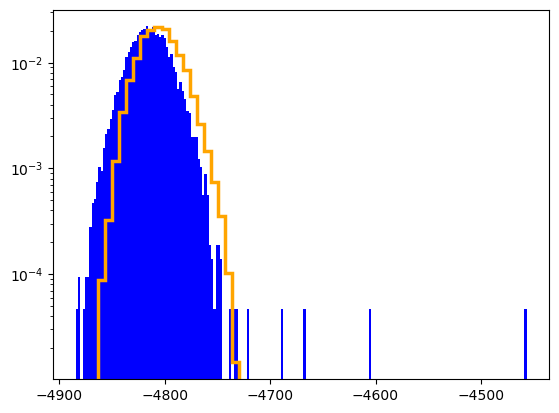

In [16]:
plt.hist(energy_encoded_data.numpy(), bins=200, linewidth=2.5, color="b", density=True, log=True)
plt.hist(energy_rbm_data.numpy(), bins=20, color="orange", density=True, fc=(1, 0, 1, 0.5), log=True, histtype='step', linewidth=2.5)
plt.show()

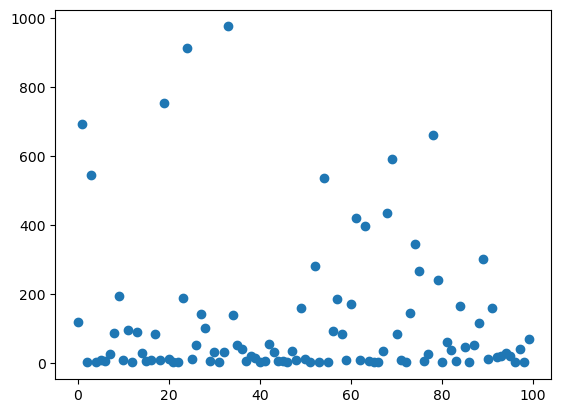

In [25]:
energy_list_subset = val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[0:100]/1000
# plt.scatter(range(100), np.sort(energy_list_subset))
plt.scatter(range(100), energy_list_subset)

In [26]:
# energy_encoded_data_per_energy.mean()


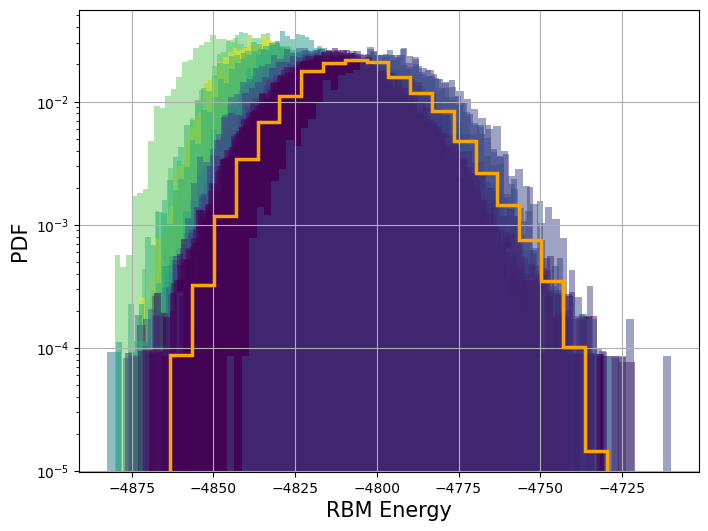

In [17]:
# ind = 10
sample_size = 1024
partition_size = config.model.n_latent_nodes
cmap = plt.cm.viridis

mean_rbm_energy = np.array([[0,0,0]])

plt.figure(figsize=(8,6))
for ind in range(0,106):
    en_ind = torch.Tensor([[val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[ind]]]).repeat(sample_size, 1)
    x_ind = val_loader.__dict__['dataset'].__dict__['_images']['showers'].__dict__['_image'][ind].unsqueeze(0).repeat(sample_size, 1)
    
    energy_encoded_data_per_energy = []
    for i in range(5):
        beta, post_logits, post_samples = engine.model.encoder(x_ind.to(dev), en_ind.to(dev), False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                         post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )

        energy_encoded_data_per_energy.append(post_samples_energy.detach().cpu())
    energy_encoded_data_per_energy = torch.cat(energy_encoded_data_per_energy, dim=0)
    
    mean_rbm_energy = np.concatenate((mean_rbm_energy, np.array([[energy_encoded_data_per_energy.mean(), en_ind[0].item(), energy_encoded_data_per_energy.std()]])), axis=0)
    
    lbl = np.round(en_ind[0].item()/1000,2)
    plt.hist(energy_encoded_data_per_energy.numpy(), color=cmap(lbl/1000), bins=60, linewidth=2.5, density=True, label=f'{lbl} GeV', log=True, alpha=0.5) 

plt.hist(energy_rbm_data.numpy(), bins=20, color="orange", density=True, fc=(1, 0, 1, 0.5), log=True, histtype='step', linewidth=2.5)
# plt.legend()
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid("True")
plt.show()
    

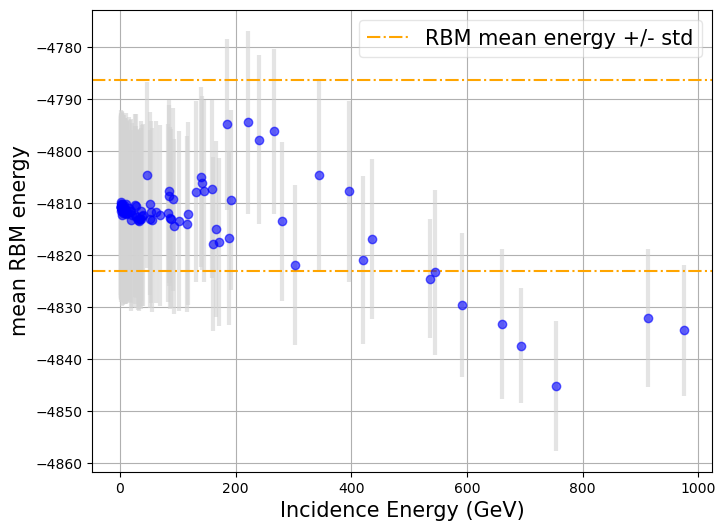

In [28]:
plt.figure(figsize=(8,6))
plt.errorbar(mean_rbm_energy[1:,1]/1000, mean_rbm_energy[1:,0], yerr=mean_rbm_energy[1:,2], fmt='o', ecolor='lightgray', elinewidth=3, capsize=0, alpha=0.6, color="blue")
# plt.scatter(mean_rbm_energy[1:,1]/1000, mean_rbm_energy[1:,0], marker='o', alpha=1, color="blue")
plt.axhline(energy_rbm_data.numpy().std() + energy_rbm_data.numpy().mean(), label="RBM mean energy +/- std", linestyle="dashdot", color='orange')
plt.axhline(-energy_rbm_data.numpy().std() + energy_rbm_data.numpy().mean(), linestyle="dashdot", color='orange')
plt.grid(True)
plt.xlabel("Incidence Energy (GeV)", fontsize=15)
plt.ylabel("mean RBM energy", fontsize=15)
plt.legend(framealpha=0.5, fontsize=15)
plt.show()

In [17]:
def error_btwn_input_and_recon_with_different_label(ind, start=3, stop=6, num=50):
    # ind = 2

    en_ind = torch.Tensor([[val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[ind]]]).repeat(sample_size, 1)
    x_ind = val_loader.__dict__['dataset'].__dict__['_images']['showers'].__dict__['_image'][ind].unsqueeze(0).repeat(sample_size, 1)
    in_data = torch.tensor(engine._data_mgr.inv_transform(x_ind.detach().cpu().numpy()))

    log_space_values = np.logspace(start=start, stop=stop, num=num, base=10)

    with torch.no_grad():
        beta, post_logits, post_samples = engine.model.encoder(x_ind.to(dev), en_ind.to(dev), False)
        post_samples = torch.cat(post_samples, 1)

        er_m_list = []
        er_std_list = []
        
        sp_er_m_list = []
        sp_er_std_list = []
        for en_prime in log_space_values:
            en_ind_prime = torch.Tensor([[en_prime]]).repeat(sample_size, 1)
            output_hits, output_activations = engine.model.decoder(post_samples, en_ind_prime.to(dev))
            beta = torch.tensor(engine.model._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)

            output_activations = engine.model._inference_energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, True)

            er = torch.pow(output_activations.sum(dim=1) - x_ind.to(dev).sum(dim=1), 2) #.cpu().numpy()
            er_m_list.append(er.mean().item()/1000)
            er_std_list.append(er.std().item()/1000)
            
            # spar_er = (((x_ind.to(dev).sign()==0).sum(dim=1)/x_ind.to(dev).shape[1] - (output_activations.sign()==0).sum(dim=1)/output_activations.shape[1])/((x_ind.to(dev).sign()==0).sum(dim=1)/x_ind.to(dev).shape[1] + 1)).cpu().numpy()
            # spar_er = (((x_ind.to(dev).sign()==0).sum(dim=1) / (output_activations.sign()==0).sum(dim=1))).cpu().numpy()
            spar_er = ((x_ind.to(dev).sign() - output_activations.sign()).abs().sum(dim=1)) #.cpu().numpy()
            sp_er_m_list.append(spar_er.mean().item())
            sp_er_std_list.append(spar_er.std().item())
            
    return er_m_list, er_std_list, log_space_values, en_ind[0].item(), in_data.sum(dim=1)[0].item(), sp_er_m_list, sp_er_std_list

In [27]:
# log_space_values[np.argmin(er_m_list)]
# (in_data.sign() - in_data.sign()).abs().sum(dim=1)
np.argsort(energy_list_subset)

array([31, 55, 22, 66, 53, 21, 86, 80,  4, 98, 46, 51, 72, 40, 12, 65,  2,
       96, 76, 41, 64, 37,  6, 45, 29, 15, 44, 83, 59, 18, 48, 10,  5, 62,
       71, 16, 20, 25, 90, 50, 39, 92, 95, 38, 93,  7, 77, 94, 14, 43, 30,
       32, 47, 67, 82, 97, 36, 85, 35, 26, 87, 42, 81, 99, 17, 70, 58,  8,
       13, 56, 11, 28, 88,  0, 34, 27, 73, 49, 91, 84, 60, 57, 23,  9, 79,
       75, 52, 89, 74, 63, 61, 68, 54,  3, 69, 78,  1, 19, 24, 33])

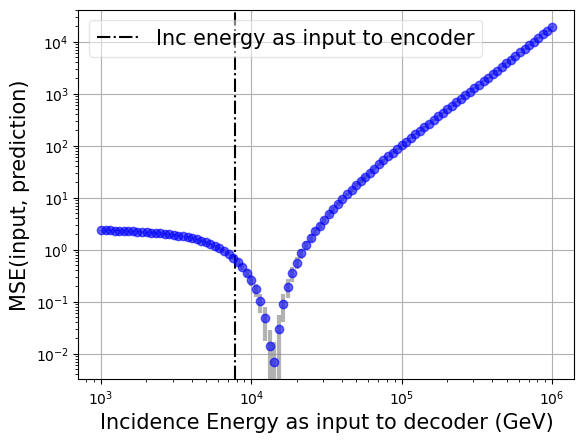

In [30]:
er_m_list, er_std_list, log_space_values, en_inc, shower_sum_in, sp_er_m_list, sp_er_std_list = error_btwn_input_and_recon_with_different_label(10, num=100)

plt.errorbar(log_space_values, er_m_list, yerr=er_std_list, fmt='o', ecolor='gray', elinewidth=3, capsize=0, alpha=0.6, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.axvline(en_inc, label="Inc energy as input to encoder", linestyle="dashdot", color='black')
# plt.axvline(shower_sum_in, c='r')
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("MSE(input, prediction)", fontsize=15)
plt.legend(framealpha=0.5, fontsize=15)
plt.show()

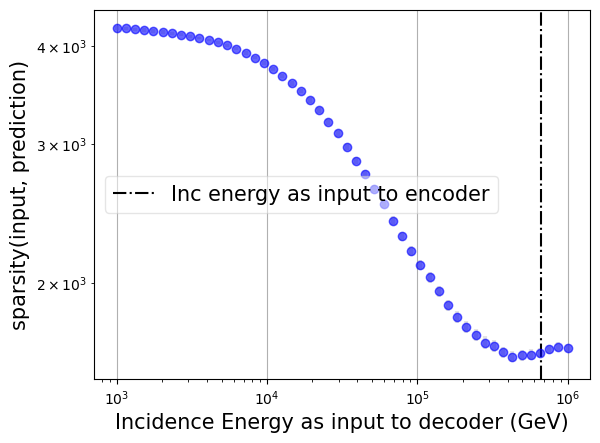

In [36]:
plt.errorbar(log_space_values, sp_er_m_list, yerr=sp_er_std_list, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0, alpha=0.6, color='blue')
plt.xscale("log")
plt.yscale("log")
plt.axvline(en_inc, label="Inc energy as input to encoder", linestyle="dashdot", color='black')
# plt.axvline(shower_sum_in, c='r')
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("sparsity(input, prediction)", fontsize=15)
plt.legend(framealpha=0.5, fontsize=15)
plt.show()

In [180]:
res_ar = torch.tensor([[0,0,0,0]])
torch.cat([res_ar, res_ar], dim=0)

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]])

In [48]:
# res_ar = torch.tensor([[0,0,0,0]])
# res_ar = np.array([[0,0,0,0]])
res_ar = torch.zeros(200,4)

for i in range(200):
    print(i)
    er_m_list, er_std_list, log_space_values, en_inc, shower_sum_in, sp_er_m_list, sp_er_std_list = error_btwn_input_and_recon_with_different_label(i, num=50)

    energy_label_min = log_space_values[torch.tensor(er_m_list).argmin().item()]
    energy_label_min_spar = log_space_values[torch.tensor(sp_er_m_list).argmin().item()]
    # res_ar = np.concatenate((res_ar, np.array([[energy_label_min, en_inc, shower_sum_in, energy_label_min_spar]])), axis=0)
    # res_ar = torch.cat([res_ar, torch.tensor([[energy_label_min, en_inc, shower_sum_in, energy_label_min_spar]])], dim=0)
    res_ar[i,:] = torch.tensor([[energy_label_min, en_inc, shower_sum_in, energy_label_min_spar]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


KeyboardInterrupt: 

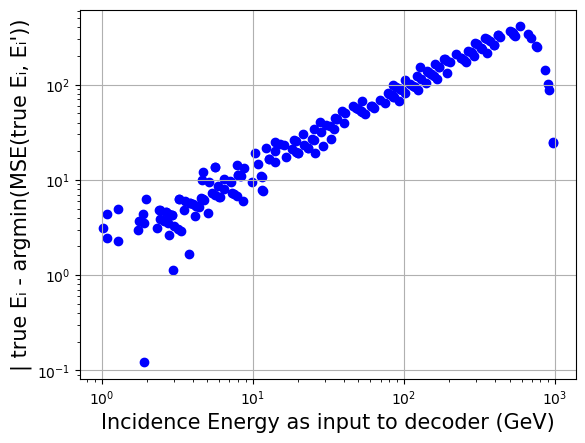

In [35]:
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,0] - res_ar[1:,1])/1000, color='b')
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("| true Eᵢ - argmin(MSE(true Eᵢ, Eᵢ'))", fontsize=15)
plt.xscale("log")
plt.yscale("log")
# plt.legend(framealpha=0.5, fontsize=15)
plt.show()

In [172]:
# m,b = np.polyfit(np.log(res_ar[1:,2]/1000), np.log((res_ar[1:,0] - res_ar[1:,2])/res_ar[1:,2]), 1)

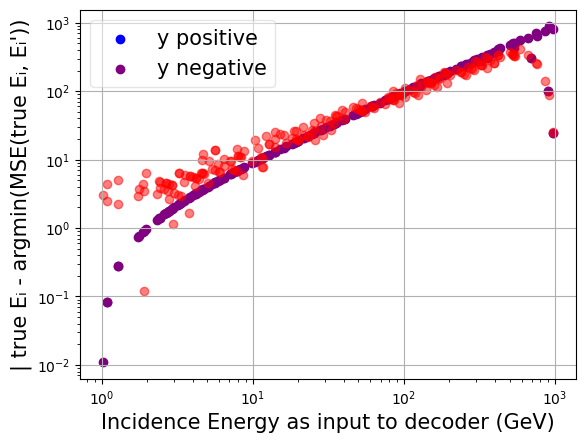

In [42]:
y = (res_ar[1:,3] - res_ar[1:,1])/1000
x = res_ar[1:,1]/1000
x_pos = x[y>0]
y_pos = y[y>0]
x_neg = x[y<0]
y_neg = y[y<0]
# plt.scatter(res_ar[1:,1]/1000, abs(res_ar[1:,3] - res_ar[1:,1])/1000, color='b')
plt.scatter(x_pos, abs(y_pos), color='b', label = 'y positive')
plt.scatter(x_neg, abs(y_neg), color='purple', label = 'y negative')
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,0] - res_ar[1:,1])/1000, color='red', alpha=0.5)
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("| true Eᵢ - argmin(MSE(true Eᵢ, Eᵢ'))", fontsize=15)
plt.legend(framealpha=0.5, fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.show()

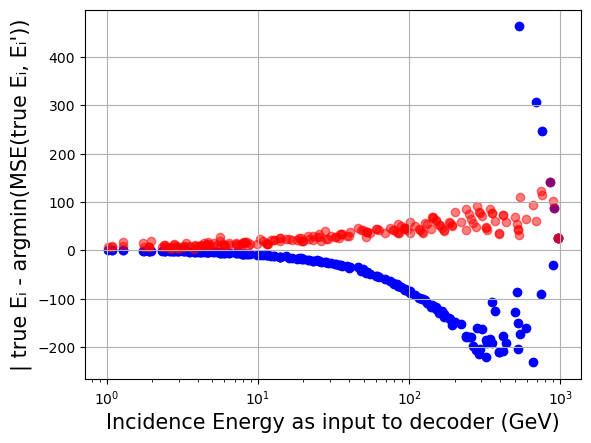

In [197]:
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,3] - res_ar[1:,1])/1000, color='b')
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,0] - res_ar[1:,1])/1000, color='red', alpha=0.5)
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("| true Eᵢ - argmin(MSE(true Eᵢ, Eᵢ'))", fontsize=15)
# plt.legend(framealpha=0.5, fontsize=15)
plt.xscale("log")
plt.show()

In [18]:
#################Hamming

In [40]:
%config InlineBackend.figure_format = 'retina'

In [21]:
# ind = 10
sample_size = 2024
partition_size = config.model.n_latent_nodes
cmap = plt.cm.viridis

enc_data_per_incE = {}

with torch.no_grad():
    for ind in range(0,50):
        en_ind = torch.Tensor([[val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[ind]]]).repeat(sample_size, 1)
        x_ind = val_loader.__dict__['dataset'].__dict__['_images']['showers'].__dict__['_image'][ind].unsqueeze(0).repeat(sample_size, 1)

        energy_encoded_data_per_energy = []

        beta, post_logits, post_samples = engine.model.encoder(x_ind.to(dev), en_ind.to(dev), False)
        post_samples = torch.cat(post_samples, 1)
        enc_data_per_incE[str(ind)] = {'inc_energy' : val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[ind],
                                      'enc_data' : post_samples}
      


In [47]:
enc_data_per_incE;

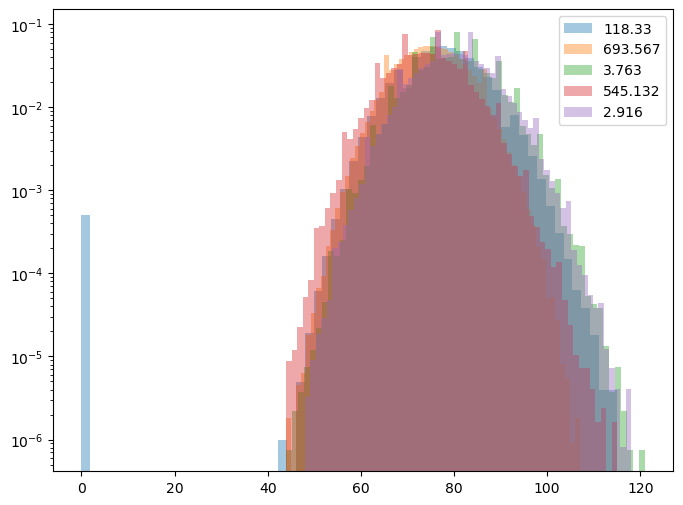

In [14]:
plt.figure(figsize=(8,6))
for i in range(5):
    plt.hist(torch.cdist(enc_data_per_incE['0']['enc_data'], enc_data_per_incE[str(i)]['enc_data']).pow(2).reshape(-1).detach().cpu().numpy(),
            label=np.round(enc_data_per_incE[str(i)]['inc_energy']/1000,3), alpha=0.4, bins=60, density=True, log=True)
plt.legend()
plt.show()

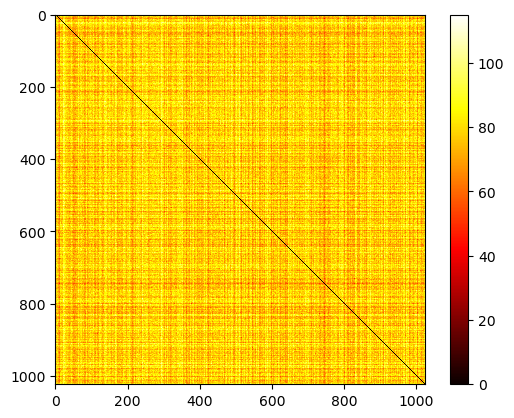

In [15]:
plt.imshow(torch.cdist(enc_data_per_incE['0']['enc_data'], enc_data_per_incE['0']['enc_data']).pow(2).detach().cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

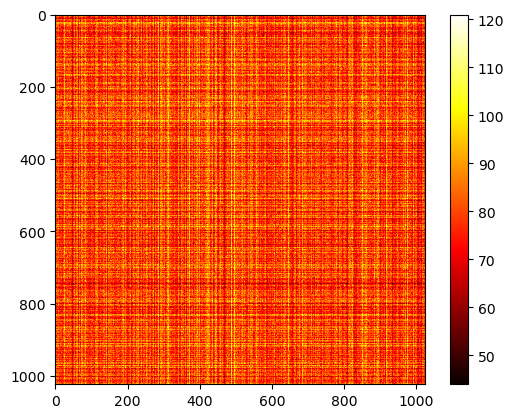

In [16]:
plt.imshow(torch.cdist(enc_data_per_incE['0']['enc_data'], enc_data_per_incE['2']['enc_data']).pow(2).detach().cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [23]:
# plt.hist(torch.cdist(enc_data_per_incE['0']['enc_data'], enc_data_per_incE['0']['enc_data']).pow(2).reshape(-1).detach().cpu().numpy(), density=True)
# plt.show()
torch.cdist(enc_data_per_incE['0']['enc_data'], enc_data_per_incE['0']['enc_data']).pow(2).sum(dim=0).shape

torch.Size([2024])

In [74]:
torch.cdist(enc_data_per_incE['0']['enc_data'], enc_data_per_incE['2']['enc_data']).pow(2).triu()

tensor([[85.0000, 77.0000, 83.0000,  ..., 93.0000, 76.0000, 88.0000],
        [ 0.0000, 84.0000, 84.0000,  ..., 90.0000, 83.0000, 93.0000],
        [ 0.0000,  0.0000, 84.0000,  ..., 90.0000, 87.0000, 85.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., 83.0000, 74.0000, 86.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 78.0000, 80.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 79.0000]],
       device='cuda:2', grad_fn=<TriuBackward0>)